In [1]:
# only run if you are in Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Some run settings

In [7]:
import os, sys
import glob
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.utils import check_X_y, safe_mask, as_float_array
import pickle

proj_path = '/content/drive/MyDrive/STAT685/685_project_repo'
# proj_path = 'G:/My Drive/STAT685/685_project_repo'
# proj_path = '/Users/rayhinton/OneDrive/OneDrive - AMNH/misc-other/school/stat685/project/685_project_repo'

# choose data set
d_choice = '8702'
# d_choice = '4302'

# number of levels of wavelet decomposition
l = 5
wavelet = 'db3'

# number of features to choose from intensity and entropy columns
nfeat_int = 10
nfeat_ent = 5

# make features with Wavelet Packet Decomposition
do_wpd_feat = True

# Choose Intensity features by Fisher criterion once or during CV
do_int_fisher_once = False

# Choose RFE or Fisher criterion for Entropy feature selection
do_rfe_for_ent = False

# whether or not to do hyperparamter tuning
do_hyper_tune = True

window_size = 1024
window_step = 500

cv_n_repeats = 1
run_prefix = '20230326_100-fisherCV'

do_undersamp = True
NUM_TRIALS = 100
refit_score = 'accuracy'

In [3]:
# Read in raw intensity data and make y variable

int_df = pd.read_csv(os.path.join(proj_path, 'DATA', f'OvarianDataset{d_choice}_intensities.csv'))
int_df.head()
int_colnames = int_df.columns

X_int = int_df.iloc[:, :-1]
y = int_df.iloc[:, -1].ravel()
print(f'{int_df.shape = }')
print(f'{X_int.shape = }')
print(f'{y.shape = }')

print(np.quantile(X_int, [0, 0.025, 0.25, .5, 0.75, 0.975, 1]))
print(np.sum(X_int.isna().to_numpy()))

int_df.shape = (253, 15155)
X_int.shape = (253, 15154)
y.shape = (253,)
[  3.7566616    4.1037707    4.547583     7.1479804   13.248869
  43.78118498 100.        ]
0


In [4]:
# function to calculate Wavelet Entropy

def wventropy(x, l, wav, mode):
  coefs = pywt.wavedec(x, wav, mode = mode, level = l)
  # just get the detail coefficients
  coefs = coefs[1:]
  # Energy at each resolution level
  E = [(np.sum(vals ** 2)) for vals in coefs]
  # Total energy
  Etot = np.sum(E)
  # Relative wavelet energies
  P = [Ej / Etot for Ej in E]
  # Total wavelet entropy
  TWE = -(np.sum(P * np.log(P)))

  assert TWE >= 0, f'Total wavelet energy must be nonnegative (got {TWE}).'

  return (TWE, P)

In [5]:
# Functions to calculate Fisher criterion, that can be used with SelectKBest()

def fisher_table(*args):
  args = [as_float_array(a) for a in args]
  fisher_score = ((np.mean(args[0], axis = 0) - np.mean(args[1], axis = 0))**2 /
    (np.var(args[0], axis = 0) + np.var(args[1], axis = 0)))
  return fisher_score

def fisher_crit(X, y):
  X, y = check_X_y(X, y)
  args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
  return fisher_table(*args)

In [6]:
# get the indices of the best Intensity columns according to Fisher criterion
int_fisher_crit = fisher_crit(X_int, y)
int_fisher_ind = np.sort(np.argsort(int_fisher_crit)[-10:])
print(int_fisher_ind)

[1677 1678 1679 1680 1681 1682 1683 2235 2236 2237]


In [25]:
# make X matrix with entropy values

if do_wpd_feat:
    X_ent = np.zeros((X_int.shape[0], 2**l))

    for i in range(X_ent.shape[0]):
        data = X_int.iloc[i, :]
        wp = pywt.WaveletPacket(data, 'db1', mode='symmetric', maxlevel=l)
        # TODO should this be 'natural' or 'freq' modes?
        coeffs = np.array([node.data for node in wp.get_level(l, 'freq')])
        # Calculate entropy per packet
        Eijk = coeffs**2
        Eij = np.sum(Eijk, axis = 1)
        pijk = Eijk / Eij[:, None]
        # numpy arrays iterate over the first axis, i.e. rows
        SEij = np.array([-sum(packet * np.log(packet)) for packet in pijk])
        X_ent[i, :] = SEij

else: 
    maxstart = X_int.shape[1] - window_size
    starts = np.arange(0, maxstart, window_step)

    X_ent = np.zeros((X_int.shape[0], len(starts)))

    print(X_int.shape[1])
    print(starts)

    for i in range(X_ent.shape[0]):
        entropies = [wventropy(X_int.iloc[i, start:(start+window_size)], l, wavelet, 'periodization')[0] for start in starts]
        X_ent[i, :] = entropies

ent_colnames = [f'ent_{i}' for i in range(X_ent.shape[1])]

X_ent = pd.DataFrame(X_ent, columns = ent_colnames)

# Select X_int based on Fisher criterion
if do_int_fisher_once:
    X_int = X_int.iloc[:, int_fisher_ind]

X = pd.concat([X_ent, X_int], axis = 1)

print(X.shape)

# print(X.iloc[0:5, 0:5])
# print(X.iloc[0:5, 29:35])

<ipython-input-25-de42803c6aea>:16: RuntimeWarning: divide by zero encountered in log
  SEij = np.array([-sum(packet * np.log(packet)) for packet in pijk])
<ipython-input-25-de42803c6aea>:16: RuntimeWarning: invalid value encountered in multiply
  SEij = np.array([-sum(packet * np.log(packet)) for packet in pijk])


(253, 15186)


In [11]:
# some checks on the derived Entropy features

# TODO add some checks for the WDP entropy features
if do_wpd_feat:
    assert True

else: 
    assert X_ent.shape[0] == X_int.shape[0], \
        f'Entropy and intensity datasets must have the same number of rows \
            (got {X_ent.shape[0]} and {X_int.shape[0]}).'

    min_ent, max_ent = np.quantile(X_ent, [0, 1])
    assert min_ent >= 0, \
        f'Minimum of the entropies cannot be less than 0 (got {min_ent}).'
    assert max_ent <= np.log(l), \
        f'Maximum entropy cannot be greater than {np.log(l)=} (got {max_ent}).'

    num_missing = X.isnull().sum().sum()
    assert  num_missing == 0, \
        f'There are {num_missing} missing values in the combined dataset.'

In [26]:
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     RepeatedStratifiedKFold, GridSearchCV,
                                     cross_validate, StratifiedKFold)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, 
                             recall_score, make_scorer)
from sklearn.preprocessing import StandardScaler, power_transform, PowerTransformer
from sklearn.feature_selection import SelectKBest, RFE, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = cv_n_repeats, random_state = 0)
rng = np.random.RandomState(0)

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'sensitivity': 'recall',
    'specificity': make_scorer(recall_score, pos_label = 0)
}

# a function to return a dataframe with useful columns from CV results
def cv_summary(cv_obj, score_names = ['score']):
  if isinstance(score_names, dict):
    score_names = list(score_names.keys())
  cv_res = pd.DataFrame(cv_obj.cv_results_)
  cols = [col for col in cv_res.columns if 'param_' in col]
  stats = ['mean', 'std', 'rank']
  test_score_names = [stat+'_test_'+score for score in score_names for stat in stats]
  test_scores = [col for col in cv_res.columns if col in test_score_names]
  cols.extend(test_scores)
  return(cv_res[cols].sort_values(test_score_names[0], ascending = False))

# Make the feature transforming pipelines

In [13]:
# making the feature transforming pipeline

# pre-processing pipeline for Intensity features

int_pipe = Pipeline([
    ('zero_var', VarianceThreshold()),
    ('skb_fish', SelectKBest(fisher_crit, k = nfeat_int)),
    ('power_trans', PowerTransformer())
])

# pre-processing pipeline for Entropy features

if do_rfe_for_ent: 
    ent_pipe = Pipeline([
        ('power_trans', PowerTransformer()),
        ('rfe', RFE(LogisticRegression(), n_features_to_select = nfeat_ent))
    ])
else: 
    ent_pipe = Pipeline([
    ('power_trans', PowerTransformer()),
    ('skb_fish', SelectKBest(fisher_crit, k = nfeat_ent))
    ])

# make column transformers to handle Intensity and Entropy separately, and also combined

int_select = np.arange(len(ent_colnames), X.shape[1])
ent_select = np.arange(len(ent_colnames))

comb_trans = ColumnTransformer([
    ('int', int_pipe, int_select),
    ('ent', ent_pipe, ent_select)
])
int_trans = ColumnTransformer([('int', int_pipe, int_select)])
ent_trans = ColumnTransformer([('ent', ent_pipe, ent_select)])

# Some EDA

NameError: ignored

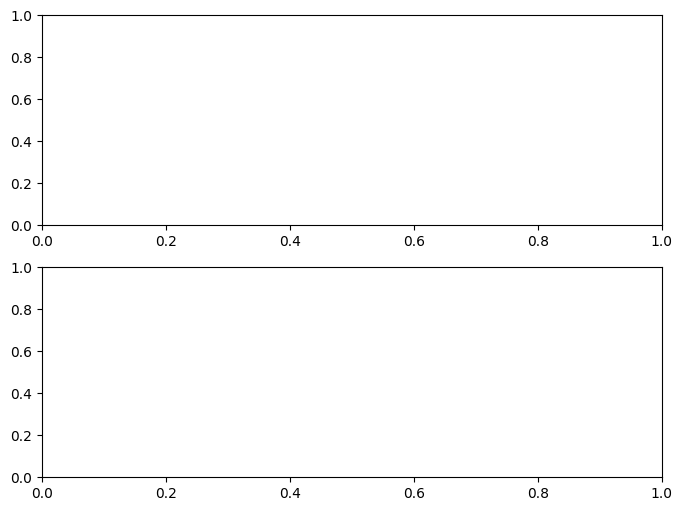

In [14]:
# Example of spectra from control and case samples

fig, axs = plt.subplots(2, 1, figsize = (8, 6))
sns.set_style("ticks")

sns.lineplot(x = np.arange(len(int_colnames)-1), color = 'steelblue', y=X_int.iloc[first_control, :], ax=axs[0])
axs[0].set_title(f'{d_choice} dataset, Control example')
axs[0].set_ylabel('Intensity')

sns.lineplot(x = np.arange(len(int_colnames)-1), color = 'steelblue', y=X_int.iloc[first_case, :], ax=axs[1])
axs[1].set_title(f'{d_choice} dataset, Case example')
axs[1].set_ylabel('Intensity')
axs[1].set_xlabel('Index of M/Z ratios')

fig.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig('PLOTS/2_background_example-protein-spectra_SEABORN.png')

(253, 15)


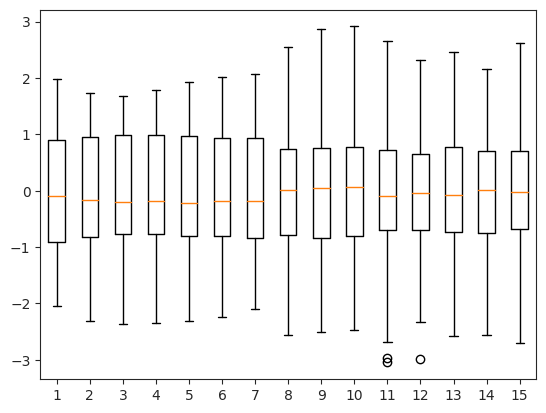

Selected entropy variables: ['ent_5' 'ent_11' 'ent_12' 'ent_17' 'ent_20']
Selected intensity variables: ['int_1677' 'int_1678' 'int_1679' 'int_1680' 'int_1681' 'int_1682'
 'int_1683' 'int_2235' 'int_2236' 'int_2237']


In [15]:
demo_trans = comb_trans.fit(X, y)
# demo_trans = int_trans.fit(X, y)

demo_trans_df = comb_trans.fit_transform(X, y)
print(demo_trans_df.shape)

plt.boxplot(demo_trans_df)
plt.show()

print(f'Selected entropy variables: {demo_trans.named_transformers_.ent.get_feature_names_out()}')
print(f'Selected intensity variables: {demo_trans.named_transformers_.int.get_feature_names_out()}')

    y       ent  window
id                     
0   1  0.144086       0
1   0 -0.015599       0
2   1  0.146340       0
3   0  0.558800       0
4   1  0.128564       0


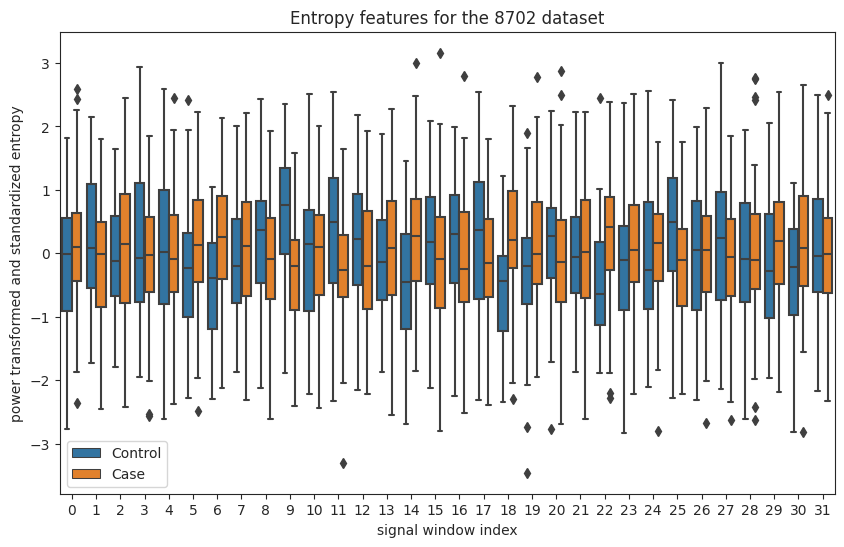

In [27]:
# show a boxplot of Entropy features - power-transformed and standardized
X_train_ent = X_train.filter(regex='ent_')
df_train = pd.DataFrame(power_transform(X_train_ent), 
                        columns = X_train_ent.columns)

df_train['y'] = y_train
df_train['id'] = df_train.index

df_train_wide = pd.wide_to_long(df = df_train, stubnames=['ent'], i = 'id', 
                                j = 'window', sep = '_')

df_train_wide['window'] = df_train_wide.index.get_level_values('window')
df_train_wide = df_train_wide.set_index(df_train_wide.index.get_level_values('id'))

print(df_train_wide.head())

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 6))
# sns.set(rc={"figure.figsize":(10,6)})
sns.set_style("ticks")

sns.boxplot(data = df_train_wide, x = 'window', y = 'ent', hue = 'y', ax=ax)
ax.set(xlabel='signal window index', 
        ylabel='power transformed and standardized entropy', 
        title=f'Entropy features for the {d_choice} dataset')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Control', 'Case'])
# plt.savefig('PLOTS/3_methodology_entropy-feature-boxplots.png')

In [20]:
# correlation of the entropy features

ent_corr = X_train.filter(regex='ent_').corr()

uptri_mask = np.triu(np.ones((29, 29)), 1).astype(np.bool_)

corrs_arr = np.reshape(ent_corr.where(uptri_mask).to_numpy(), -1)
corrs_arr = corrs_arr[~np.isnan(corrs_arr)]
print(pd.DataFrame(np.abs(corrs_arr)).describe())

corrs_quant = np.quantile(np.abs(corrs_arr), [0, 0.10, 0.25, 0.5, 0.75, 0.90, 1])
print([f'{quant:.4g}' for quant in corrs_quant])

sns.heatmap(ent_corr, vmin = -1, vmax = 1, cmap = 'vlag')

ValueError: ignored

# LR

In [ ]:
# Logistic regression - hyperparameters and pipelines

# LR C grid based on range from LogisticRegressionCV:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                            max_iter = 10**6, random_state = rng)
lr_params = {'logreg__C': np.logspace(-4, 4, 9),
            #  'logreg__class_weight': ['balanced', None],
             'logreg__l1_ratio': [0, 0.5, 1]}

ent_lr_pipe = Pipeline([
    ('ent_trans', ent_trans),
    ('logreg', logreg)
])

int_lr_pipe = Pipeline([
    ('int_trans', int_trans),
    ('logreg', logreg)
])

comb_lr_pipe = Pipeline([
    ('comb_trans', comb_trans),
    ('logreg', logreg)
])

# parameters and pipelines for no hyperparameter tuning

logreg_def = LogisticRegression(solver='saga', max_iter=10**6, random_state=rng)
lr_def_params = {'logreg_def__penalty': None}

ent_lr_def_pipe = Pipeline([
    ('ent_trans', ent_trans),
    ('logreg_def', logreg_def)
])
int_lr_def_pipe = Pipeline([
    ('int_trans', int_trans),
    ('logreg_def', logreg_def)
])
comb_lr_def_pipe = Pipeline([
    ('comb_trans', comb_trans),
    ('logreg_def', logreg_def)
])

## Fit LR

In [ ]:
# Fit LR with combined features

comb_lr_cv = GridSearchCV(comb_lr_pipe, param_grid=lr_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

comb_lr_cv.fit(X_train, y_train)

comb_lr_cv_summ = cv_summary(comb_lr_cv, scoring)

print(comb_lr_cv.best_score_)
print(comb_lr_cv_summ['mean_test_accuracy'].max())

comb_lr_cv_summ.head()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.9907861369399831
0.9695156695156694


,param_logreg__C,param_logreg__l1_ratio,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_sensitivity,std_test_sensitivity,rank_test_sensitivity,mean_test_specificity,std_test_specificity,rank_test_specificity
15,10.0,0,0.990786,0.010971,1,0.947293,0.039126,11,0.940659,0.029772,12,0.954945,0.061026,8
26,10000.0,1,0.989687,0.010244,2,0.939886,0.038964,14,0.940659,0.029772,12,0.939560,0.057312,13
25,10000.0,0.5,0.989687,0.010244,2,0.939886,0.038964,14,0.940659,0.029772,12,0.939560,0.057312,13
24,10000.0,0,0.989687,0.010244,2,0.939886,0.038964,14,0.940659,0.029772,12,0.939560,0.057312,13
23,1000.0,1,0.989687,0.010244,2,0.939886,0.038964,14,0.940659,0.029772,12,0.939560,0.057312,13


In [ ]:
# Fit LR with entropy features

ent_lr_cv = GridSearchCV(ent_lr_pipe, param_grid=lr_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

ent_lr_cv.fit(X_train, y_train)

ent_lr_cv_summ = cv_summary(ent_lr_cv, scoring)

print(ent_lr_cv.best_score_)
print(ent_lr_cv_summ['mean_test_accuracy'].max())

print(ent_lr_cv_summ.head())

print(ent_lr_cv_summ.sort_values('mean_test_accuracy', ascending=False).head())

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.8956889264581573
0.8284900284900285
   param_logreg__C param_logreg__l1_ratio  mean_test_roc_auc  \
14             1.0                      1           0.895689   
13             1.0                    0.5           0.894675   
9              0.1                      0           0.893660   
10             0.1                    0.5           0.892815   
12             1.0                      0           0.891293   

    std_test_roc_auc  rank_test_roc_auc  mean_test_accuracy  \
14          0.052054                  1            0.820513   
13          0.056715                  2            0.820513   
9           0.056391                  3            0.828490   
10          0.053563                  4            0.828490   
12          0.056017                  5            0.827920   

    std_test_accuracy  rank_test_accuracy  mean_test_sensitivity  \
14           0.045047                  16               0.821978   


In [ ]:
# Fit LR with intensity features

int_lr_cv = GridSearchCV(int_lr_pipe, param_grid=lr_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

int_lr_cv.fit(X_train, y_train)

int_lr_cv_summ = cv_summary(int_lr_cv, scoring)

print(int_lr_cv.best_score_)
print(int_lr_cv_summ['mean_test_accuracy'].max())

print(int_lr_cv_summ.head())

y_pred = int_lr_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.9885038038884193
0.9695156695156694
   param_logreg__C param_logreg__l1_ratio  mean_test_roc_auc  \
14             1.0                      1           0.988504   
11             0.1                      1           0.988419   
13             1.0                    0.5           0.985038   
16            10.0                    0.5           0.983939   
10             0.1                    0.5           0.982840   

    std_test_roc_auc  rank_test_roc_auc  mean_test_accuracy  \
14          0.014715                  1            0.954701   
11          0.016228                  2            0.969516   
13          0.019371                  3            0.969516   
16          0.018633                  4            0.939886   
10          0.021203                  5            0.969516   

    std_test_accuracy  rank_test_accuracy  mean_test_sensitivity  \
14           0.037865                   6               0.956044   


# SVM

In [ ]:
# SVM - hyperparameters and pipelines

from sklearn.svm import SVC

# Example of making a parameter grid, since SVC uses different basis functions
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#tuning-hyper-parameters

# grid suggestions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

svm__C = np.logspace(-3, 3, 5)
svm__gamma = np.logspace(-3, 3, 5)

svm_params = [
    {'svm__kernel': ['linear'], 'svm__C': svm__C},
    {'svm__kernel': ['rbf'], 'svm__C': svm__C, 'svm__gamma': svm__gamma},
    {'svm__kernel': ['poly'], 'svm__C': svm__C, 'svm__gamma': svm__gamma}
]

svm = SVC(max_iter=10 ** 7)

ent_svm_pipe = Pipeline([
    ('ent_trans', ent_trans),
    ('svm', svm)
])

comb_svm_pipe = Pipeline([
    ('comb_trans', comb_trans),
    ('svm', svm)
])

int_svm_pipe = Pipeline([
    ('int_trans', int_trans),
    ('svm', svm)
])

## Fit SVM

In [ ]:
# Fit SVM with entropy features

ent_svm_cv = GridSearchCV(ent_svm_pipe, param_grid=svm_params, scoring = scoring, 
                     n_jobs=1, refit='roc_auc', cv=cv, verbose = 4)

ent_svm_cv.fit(X_train, y_train)

ent_svm_cv_summ = cv_summary(ent_svm_cv, scoring)

print(ent_svm_cv.best_estimator_[1].n_iter_)

print(ent_svm_cv_summ['mean_test_accuracy'].max())
print(ent_svm_cv_summ.head())

[123]
0.8282051282051281
   param_svm__C param_svm__kernel param_svm__gamma  mean_test_roc_auc  \
16          1.0               rbf         0.031623           0.886685   
6         0.001               rbf         0.031623           0.882326   
11     0.031623               rbf         0.031623           0.882326   
7         0.001               rbf              1.0           0.879939   
12     0.031623               rbf              1.0           0.879939   

    std_test_roc_auc  rank_test_roc_auc  mean_test_accuracy  \
16          0.044888                  1            0.828205   
6           0.051148                  2            0.544729   
11          0.051148                  2            0.544729   
7           0.063280                  4            0.544729   
12          0.063280                  4            0.544729   

    std_test_accuracy  rank_test_accuracy  mean_test_sensitivity  \
16           0.019482                   1               0.849524   
6            0.014683

In [ ]:
# Fit SVM with combined features

comb_svm_cv = GridSearchCV(comb_svm_pipe, param_grid=svm_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

comb_svm_cv.fit(X_train, y_train)

comb_svm_cv_summ = cv_summary(comb_svm_cv, scoring)
print(comb_svm_cv_summ['mean_test_accuracy'].max())
print(comb_svm_cv_summ.head())

Fitting 5 folds for each of 55 candidates, totalling 275 fits
0.9623931623931623
   param_svm__C param_svm__kernel param_svm__gamma  mean_test_roc_auc  \
21    31.622777               rbf         0.031623           0.989687   
3     31.622777            linear              NaN           0.989687   
4        1000.0            linear              NaN           0.989687   
26       1000.0               rbf         0.031623           0.989687   
2           1.0            linear              NaN           0.987489   

    std_test_roc_auc  rank_test_roc_auc  mean_test_accuracy  \
21          0.011362                  1            0.962393   
3           0.010244                  1            0.939886   
4           0.010244                  1            0.939886   
26          0.011362                  1            0.954986   
2           0.013249                  5            0.954701   

    std_test_accuracy  rank_test_accuracy  mean_test_sensitivity  \
21           0.024335            

In [ ]:
# Fit SVM with intensity features

int_svm_cv = GridSearchCV(int_svm_pipe, param_grid=svm_params, scoring = scoring, 
                     n_jobs=-1, refit='roc_auc', cv=cv, verbose = 4)

int_svm_cv.fit(X_train, y_train)

int_svm_cv_summ = cv_summary(int_svm_cv, scoring)
print(int_svm_cv_summ['mean_test_accuracy'].max())
print(int_svm_cv_summ.head())

# KNN

In [1]:
# KNN - hyperparemeters and pipelines

from sklearn.neighbors import KNeighborsClassifier

knn_params = {'knn__n_neighbors': range(1, 33, 2)}

knn = KNeighborsClassifier()

ent_knn_pipe = Pipeline([
    ('ent_trans', ent_trans),
    ('knn', knn)
])

comb_knn_pipe = Pipeline([
    ('comb_trans', comb_trans),
    ('knn', knn)
])

int_knn_pipe = Pipeline([
    ('int_trans', int_trans),
    ('knn', knn)
])

NameError: ignored

## Fit KNN

In [22]:
# Fit KNN with entropy features

ent_knn_cv = GridSearchCV(ent_knn_pipe, param_grid=knn_params, scoring = scoring, 
                     n_jobs=-1, refit='accuracy', cv=cv, verbose = 4)

ent_knn_cv.fit(X_train, y_train)

ent_knn_cv_summ = cv_summary(ent_knn_cv, scoring)
print(ent_knn_cv_summ['mean_test_accuracy'].max())
print(ent_knn_cv_summ.head())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.8518716577540106
   param_knn__n_neighbors  mean_test_roc_auc  std_test_roc_auc  \
8                      17           0.919216          0.053178   
9                      19           0.919216          0.049517   
10                     21           0.916614          0.046733   
14                     29           0.914667          0.049185   
11                     23           0.913976          0.044958   

    rank_test_roc_auc  mean_test_accuracy  std_test_accuracy  \
8                   1            0.851872           0.049896   
9                   1            0.845811           0.055181   
10                  3            0.845811           0.055181   
14                  4            0.839750           0.056586   
11                  5            0.851693           0.054048   

    rank_test_accuracy  mean_test_sensitivity  std_test_sensitivity  \
8                    1               0.916883              0.067906

In [24]:
# Fit KNN with combined features

comb_knn_cv = GridSearchCV(comb_knn_pipe, param_grid=knn_params, scoring = scoring, 
                     n_jobs=-1, refit='accuracy', cv=cv, verbose = 4)

comb_knn_cv.fit(X_train, y_train)

comb_knn_cv_summ = cv_summary(comb_knn_cv, scoring)
print(comb_knn_cv_summ['mean_test_accuracy'].max())
print(comb_knn_cv_summ.head())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.9823529411764707
   param_knn__n_neighbors  mean_test_roc_auc  std_test_roc_auc  \
5                      11           0.998864          0.002273   
6                      13           0.998485          0.002209   
13                     27           0.998485          0.001856   
7                      15           0.998106          0.002396   
12                     25           0.998106          0.002396   

    rank_test_roc_auc  mean_test_accuracy  std_test_accuracy  \
5                   1            0.982353           0.014409   
6                   2            0.982353           0.014409   
13                  2            0.982353           0.014409   
7                   4            0.982353           0.014409   
12                  4            0.982353           0.014409   

    rank_test_accuracy  mean_test_sensitivity  std_test_sensitivity  \
5                    1               0.981818              0.022268

In [ ]:
# KNN with just the intensity features

int_knn_cv = GridSearchCV(int_knn_pipe, param_grid=knn_params, scoring = scoring, 
                     n_jobs=-1, refit='accuracy', cv=cv, verbose = 4)

int_knn_cv.fit(X_train, y_train)

int_knn_cv_summ = cv_summary(int_knn_cv, scoring)
print(int_knn_cv_summ['mean_test_accuracy'].max())
print(int_knn_cv_summ.head())

# Nested cross validation

In [ ]:
# nested cross validation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

# more about cross validation and model selection, performance
# https://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf
# https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

import copy

is_stack_clf = False
# chosen_pipe = copy.deepcopy(stack_knn_est)
chosen_pipe = copy.deepcopy(ent_knn_pipe)
param_grid = copy.deepcopy(knn_params)

# these are used to print out results later
scores = list(scoring.keys())
test_scores = [f'test_{score}' for score in scores]

def run_nest_cv(chosen_pipe, X, y, param_grid, scoring, refit_score, NUM_TRIALS, do_undersamp = False):

    nested_scores = []
    for i in range(NUM_TRIALS):
        print(f'##### Starting trial {i} #####')

        inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=i)
        outer_cv = StratifiedKFold(n_splits=3, shuffle = True, random_state = i)

        clf = GridSearchCV(chosen_pipe, param_grid=param_grid, scoring = scoring, 
                            refit=refit_score, cv=inner_cv, n_jobs = -1, verbose = 1)

        # manually do undersampling
        if do_undersamp:
            allXy = copy.deepcopy(X)
            allXy['y'] = copy.deepcopy(y)
            to_samp = allXy.value_counts('y').sort_values()[0]

            resamp_Xy = allXy.groupby('y', group_keys=False).apply(lambda x: x.sample(to_samp, random_state = i))

            this_X = resamp_Xy.drop(['y'], axis = 1)
            this_y = resamp_Xy['y']
        else:
            this_X = copy.deepcopy(X)
            this_y = copy.deepcopy(y)

        nested_results = cross_validate(clf, this_X, this_y, scoring = scoring, cv = outer_cv, verbose = 4)
        nested_scores.append(nested_results)
        
    return nested_scores

In [ ]:
# Run a single Nested CV for a chosen alg and feature pipe

nested_scores = run_nest_cv(chosen_pipe, X, y, param_grid, scoring, refit_score, NUM_TRIALS, do_undersamp)

## Nested CV results

In [ ]:
# list comprehension over a dictionary comprehension 
nest_cv_summ = pd.DataFrame([{k: np.mean(i[v]) for (k, v) in zip(scores, test_scores)} for i in nested_scores])
print(len(nested_scores))
print(nest_cv_summ)
print(nest_cv_summ.mean())

2
    roc_auc  accuracy  sensitivity  specificity
0  0.851874  0.804689     0.929887     0.677065
1  0.827900  0.759460     0.860368     0.656863
roc_auc        0.839887
accuracy       0.782074
sensitivity    0.895128
specificity    0.666964
dtype: float64


# Fit all models and save results

In [ ]:
alg_dicts = {
    # 'LR': {
    #     'params': lr_params, 
    #     'pipes': {'ent': ent_lr_pipe, 'int': int_lr_pipe, 'comb': comb_lr_pipe}
    #     },
    'SVM': {
        'params': svm_params,
        'pipes': {'ent': ent_svm_pipe, 'int': int_svm_pipe, 'comb': comb_svm_pipe}
        }#,
    # 'KNN': {
    #     'params': knn_params,
    #     'pipes': {'ent': ent_knn_pipe, 'int': int_knn_pipe, 'comb': comb_knn_pipe}
    #     }
}

all_results = {}
os.makedirs(os.path.join(proj_path, 'RESULTS'), exist_ok = True)

for alg_name, alg_dict in alg_dicts.items():
    print(f'##### Starting {alg_name} #####')
    feats_dict = {}
    for feats, pipe in alg_dict['pipes'].items():
        print(f'##### Starting {alg_name} using {feats=} #####')

        # run the function and save the scores
        this_score = run_nest_cv(pipe, X, y, alg_dict['params'], scoring, 
                                 refit_score, NUM_TRIALS = NUM_TRIALS, 
                                 do_undersamp = do_undersamp)
        # save the results to a file
        scores_filename = f'{run_prefix}_{d_choice}_{alg_name}_{feats}_nested_scores.pkl'
        scores_path = os.path.join(proj_path, 'RESULTS',
                                       scores_filename)
        with open(scores_path, 'wb') as file:
            pickle.dump(this_score, file)
        
        feats_dict[feats] = copy.deepcopy(this_score)
    all_results[alg_name] = copy.deepcopy(feats_dict)

## summarize all models

In [ ]:
# make a dataframe summarizing the results

scoresumm = []
alg_name_col = []
feat_name_col = []

for alg_name, feats in all_results.items():
    for feat, feat_res in feats.items():
        this_nest_summ = pd.DataFrame([{k: np.mean(i[v]) for (k, v) in zip(scores, test_scores)} for i in feat_res])
        scoresumm.extend(this_nest_summ.mean().to_numpy())
        alg_name_col.append(alg_name)
        feat_name_col.append(feat)

df_summ = pd.DataFrame(np.asarray(scoresumm).reshape(-1, 4), columns = scores)
df_summ['alg'] = alg_name_col
df_summ['feats'] = feat_name_col
df_summ.set_index(['alg', 'feats'], inplace=True)

print(df_summ)

            roc_auc  accuracy  sensitivity  specificity
alg feats                                              
SVM ent    0.846935  0.769182     0.830615     0.705374
    int    0.979903  0.960384     0.971040     0.949507
    comb   0.986672  0.953550     0.966361     0.940520
